https://doc.sagemath.org/html/en/reference/rings_numerical/sage/rings/real_arb.html#sage.rings.real_arb.RealBall.accuracy


DIRE QUE RIDGE C'EST BIEN QUAND LE CONDITIONNEMENT EST GUEZ CAD QUAND ON CONCENTRE LES POINTS POUR UNE SINGULARITE,TYPIQUEMENT CE QUON FAIT POUR LE NOYAU DU PROBLEME  
Faire le meme test sur un autre set mais en 2D pour le noyau ( ca devrais etre encore mieux car varie plus donc methode plus stable marche mieux)  
Finir et clean les exemples, en mettant les bons commenatires (cf ci-dessus)  
plot avec signe les noyaux  
tester d'abord sur du 1/x , en tweakant le eta_3  
# TODO

## Stability and Conditioning

- Check if the conditioning is affecting the stability of the approximation.
- Optimize the code and check the RBF conversions.
- Add weights and try to figure out how to use the theoretical *eta* function.
- Try to estimate the radius of density around the critical diagonal that we should have in order to correct the asymmetry of `grid_concentrated`.

## Quadrature and Integration

- Implement Gauss quadrature.
- Repair `RIF` to obtain precise uniform bounds on integral approximations.
  - Alternatively, try bounding `lambda` and `phi` separately to get a rough bound.

---

## Coding Goals

1. Now that smooth and nice functions are well approximated, try to approximate toy examples of wild (smooth) functions.  
2. Improve the rate of convergence.  
   - As of now, the finite-rank kernel converges quickly to a reasonable approximation, but then struggles to really converge.  
3. Repair the singular functions in order to use `RIF` to compute maximums.  
   - To experiment with `RIF`, try computing the max of a smooth function that reaches its maximum between `0` and `2^(-prec)`.  
4. Check that everything is properly converted into RBF.

---

## Theoretical Goals

1. Check the computations for the approximated kernel.  
2. Bound the L² / H³ norm of the kernels (both real and approximated) away from zero.


We want to approximate in $H^3(\mathbb{R})$ the kernel operator $T : f \mapsto \displaystyle \int_\mathbb{R} K(x,y)f(y)\mathrm{d}y$ using gaussians.  
Assuming that we can bound the kernel away from zero, we only need to find an approximation on a bounded (compact) domain $[-A,A]$, provided that the approximation also decays fast enough at infinity.  
We first discretize the integral operator using a Riemann sum : $ T(f)(x) \approx \displaystyle \sum_{i=1}^n \delta K(x,y_i)f(y_i) $  
Then we approximate each $K(x,y_i)$ separately using gaussians (maybe we should directly approximate the Riemann sum): $K(x,y_i) \approx \displaystyle \sum_{j=1}^n c_{i,j} e^{-\frac{(x-x_j)^2}{2\sigma}} $  
Finally, since $f\mapsto f(x_i)$ is represented in $H^3(\mathbb{R})$ by the inverse Fourier transform of $\displaystyle \frac{e^{2i\pi \xi x_i}}{(1+\xi^2)^3}$, denoted $\eta_{x_i}(x)$, the approximate operator can be written as :  
$T_n : f \mapsto \displaystyle \int_\mathbb{R} K_n(x,y)f(y)\mathrm{d}y$, where $K_n(x,y) = \displaystyle \sum_{i=1}^n \sum_{j=1}^n \delta c_{i,j} e^{ \frac{(x-x_j)^2}{2\sigma}}\eta_{y_i}(y) $.

We now need to numerically compute the  norm of the difference in $H^3([-A,A])$ with rigorous bounds, and hope that it is small enough for a not too large $n$.

# 1 - Kernel approximation by Gaussians

In [98]:
## Adding the .simplify_full() command may give cleaner functions to look at, but drastically increases the runtime (from 0.5 sec to more than 4 min), and, most importantly, causes completely unstable computations that ruin the precision (for unknown reasons).
import numpy as np
from sage.rings import real_mpfi
real_mpfi.printing_style = 'brackets'

prec = 300
RBF = RealBallField(prec)
RIF = RealIntervalField(prec)
var('x')
assume(x, 'real')
var('y')
assume(y, 'real')

n_derivs=10  # Number of derivatives to compute


W = (-x/2 + sqrt(1/27 + x^2/4))^(1/3) - (x/2 + sqrt(1/27 + x^2/4))^(1/3)
W_prime = diff(W, x)
a = 1 + W/x + W_prime
b = (3*x)/2 + W
a_derivs = [a]
a_derivs_0=[RBF(a_derivs[0].taylor(x,0,0))]
b_derivs = [b]
b_derivs_0=[RBF(b_derivs[0].taylor(x,0,0))]
for k in range(1, n_derivs):
    a_derivs.append(diff(a, x, k))
    a_derivs_0.append(RBF(a_derivs[k].taylor(x,0,0)))
    b_derivs.append(diff(b, x, k))
    b_derivs_0.append(RBF(b_derivs[k].taylor(x,0,0)))


phi_0 = -a_derivs[0] + b_derivs[1]/2 + a_derivs[2]/2 - a_derivs[4]/2 + a_derivs[6]/2
phi_1 = -a_derivs[0] - b_derivs[1]/2 + 2*a_derivs[2] + b_derivs[3]/2 - 3*a_derivs[4] - b_derivs[5]/2
phi_2 = -a_derivs[0] - (3/2)*b_derivs[1] + (9/2)*a_derivs[2] + (5/2)*b_derivs[3] 
phi_3 = -a_derivs[0] - (5/2)*b_derivs[1] # corresponds to the sign in the inequality
phi_list = [phi_0, phi_1, phi_2, phi_3]

phi_0_0 = -a_derivs_0[0] + b_derivs_0[1]/2 + a_derivs_0[2]/2 - a_derivs_0[4]/2 + a_derivs_0[6]/2
phi_1_0 = -a_derivs_0[0] - b_derivs_0[1]/2 + 2*a_derivs_0[2] + b_derivs_0[3]/2 - 3*a_derivs_0[4] - b_derivs_0[5]/2
phi_2_0 = -a_derivs_0[0] - (3/2)*b_derivs_0[1] + (9/2)*a_derivs_0[2] + (5/2)*b_derivs_0[3]
phi_3_0 = -a_derivs_0[0] - (5/2)*b_derivs_0[1]  
phi_list_0 = [phi_0_0, phi_1_0, phi_2_0, phi_3_0]


# Base Fourier function
f = (pi/4) * exp(-2*pi*abs(x)) * (2*(pi**2)*(x**2) + 3*pi*abs(x) + 3/2)
lambda_0 = f
lambda_1 = -diff(f, x)
lambda_2 = -diff(f, x, 2)
lambda_3 = 2*diff(f, x, 3)
lambda_4 = diff(f, x, 4)
lambda_5 = diff(f, x, 5)
lambda_6 = diff(f, x, 6)
lambda_list = [lambda_0,lambda_1,lambda_2,lambda_3,lambda_4,lambda_5,lambda_6]
lambda_list_0 = [limit(lambda_0,x=0),limit(lambda_1,x=0),limit(lambda_2,x=0),limit(lambda_3,x=0),limit(lambda_4,x=0),limit(lambda_5,x=0),limit(lambda_6,x=0)]


M_0 = (lambda_list[0](x=x - y) * phi_list[0](x=y))
M_1 = (lambda_list[1](x=x - y) * diff(phi_list[1], x)(x=y) + lambda_list[2](x=x - y) * phi_list[1](x=y))
M_2 = (lambda_list[3](x=x - y) * diff(diff(phi_list[2], x),x)(x=y) +lambda_list[3](x=x - y) * diff(phi_list[2], x)(x=y)+ lambda_list[4](x=x - y) * phi_list[2](x=y))
M_list=[M_0,M_1,M_2]


# Converts symbolic functions to numerical ones that have RealBallField for domain, and repair the numerical singularities at 0.

def smooth_fast_callable(f,x,zero_value=RBF(0)):
    f_fast = fast_callable(f, vars=[x], domain=RBF)
    def f_modified(ball):
        return RBF(zero_value) if abs(RBF(ball).center()) <= 2**(-prec+1) else f_fast(RBF(ball)) # Sets the sensibility to be equal to the precision of the field
    return f_modified

a_funcs = [smooth_fast_callable(a_derivs[k],x,a_derivs_0[k]) for k in range(n_derivs)]
b_funcs = [smooth_fast_callable(b_derivs[k],x,b_derivs_0[k]) for k in range(n_derivs)]
phi_funcs = [smooth_fast_callable(phi_list[k],x,phi_list_0[k]) for k in range(4)]
lambda_funcs = [smooth_fast_callable(lambda_list[k],x,lambda_list_0[k]) for k in range(7)]

phi_1_d1_0=diff(phi_list[1],x).taylor(x,0)
phi_1_d1_func=smooth_fast_callable(diff(phi_list[1],x),x,phi_1_d1_0)

phi_2_d1_0=diff(phi_list[2],x).taylor(x,0)
phi_2_d1_func=smooth_fast_callable(diff(phi_list[2],x),x,phi_2_d1_0)
phi_2_d2_0=diff(diff(phi_list[2],x),x).taylor(x,0)
phi_2_d2_func=smooth_fast_callable(diff(diff(phi_list[2],x),x),x,phi_2_d2_0)

def M_0_func(ball1,ball2):
   return lambda_funcs[0](ball1-ball2)*phi_funcs[0](ball2)
    
def M_1_func(ball1, ball2):
    return (lambda_funcs[1](ball1-ball2) * phi_1_d1_func(ball2) + lambda_funcs[2](ball1-ball2) * phi_funcs[1](ball2))

def M_2_func(ball1, ball2):
    return (lambda_funcs[3](ball1-ball2) * phi_2_d2_func(ball2) + lambda_funcs[3](ball1-ball2) * phi_2_d1_func(ball2) + lambda_funcs[4](ball1-ball2) * phi_funcs[2](ball2))

M_funcs=[M_0_func,M_1_func,M_2_func]

In [125]:
def check_pos(f,divs):
    for i in range(divs):
        interval=RBF(RIF((-1+(2*i/divs)),(-1+(2*(i+1)/divs))))
        check = RBF(f(interval))
        print(check.mid(),"+/-",check.rad(),check>0)

def rigorous_max_partial_derivatives(fx,fy, x1, x2, y1, y2):
    I_x = RBF(x1, x2)
    I_y = RBF(y1, y2)

    fx_eval = RBF(fx(x=I_x, y=I_y))
    fy_eval = RBF(fy(x=I_x, y=I_y))

    fx_sup = RBF(max(abs(fx_eval.lower()), abs(fx_eval.upper())))
    fy_sup = RBF(max(abs(fy_eval.lower()), abs(fy_eval.upper())))

    return fx_sup, fy_sup

#max_fx, max_fy = rigorous_max_partial_derivatives(f_expr, x1, x2, y1, y2)
# largeur = R(x2) - R(x1)
# hauteur = R(y2) - R(y1)
# error_bound = (largeur * hauteur / n) * (largeur * max_fx + hauteur * max_fy)
# print(f"Borne d'erreur théorique (approx.) : {error_bound}")

In [43]:
def grid(A,n,B=NaN,offset=0):
    if B==NaN:
        B=A ; A=-B
    if n==1:
        return [A]
    return ([A + (B-A)*(i+offset)/(n-1) for i in range(n)])

def grid_concentrated(A, B, y, n):
    t = grid(1,n)
    t_concentrated = [xi * abs(xi)**0.5 for xi in t]
    left_length = y - A
    right_length = B - y
    points = []
    for xi in t_concentrated:
        if xi < 0:
            val = y + xi * left_length
        else:
            val = y + xi * right_length
        points.append(RBF(val))
    return points

def riemann_sum(f, y1, y2, n):
    y_points = grid(y1,n,y2)
    def g(x):
        return sum(RBF(delta) * RBF(f(x, y_i)) for y_i in y_points)
    return y_points,g

def riemann_integral(f, x1, x2, y1, y2, n):
    dx = (RBF(x2) - RBF(x1))/n
    dy = (RBF(y2) - RBF(y1))/n
    total = RBF(0)
    for i in range(n):
        for j in range(n):
            xi = RBF(x1) + i*dx
            yj = RBF(y1) + j*dy
            total += f(xi, yj) * dx * dy
            if f(xi,yj).is_NaN():
                print(yj.center())
                print()
            sys.stdout.write(f"\rIntegral computation : {int(((n*i+j) / (n**2)) * 100)}%") # Progress bar
            sys.stdout.flush()
    sys.stdout.write("\r" + " " * 30 + "\r")
    sys.stdout.flush()
    return total 

def delta_squared(K1,K2):
    def f(x,y):
        return (K1(x,y)-K2(x,y))**2
    return f

def delta_abs(K1,K2):
    def f(x,y):
        return abs(K1(x,y)-K2(x,y))
    return f

def delta_log(K1,K2):
    def f(x,y):
        return log(1+abs(K1(x,y)-K2(x,y)))
    return f

In [ ]:
def G_even(q, center, sig):
    return exp(-(q-center)**2/(2 * sig**2)) + exp(-(q+center)**2/(2 * sig**2))

def G(q, center, sig):
    return exp(-(q-center)**2/(2 * sig**2))

var('p, q, r')
fG = fast_callable(G(p, q, r), vars=[p, q, r], domain=RR)
fG_even = fast_callable(G_even(p, q, r), vars=[p, q, r], domain=RR)

def fit_num_ridge(func, basis_pts, train_pts, sigma=1/2, basis_type='G', alpha=None, mode='ridge'):
    true_vals = vector(RR, [func(x) for x in train_pts])
    basis_num = len(basis_pts)
    train_num = len(train_pts)

    if basis_type == 'G':
        M = matrix(RR, train_num, basis_num, lambda i, j: fG(train_pts[i], basis_pts[j], sigma))
    elif basis_type == 'G_even':
        M = matrix(RR, train_num, basis_num, lambda i, j: fG_even(train_pts[i], basis_pts[j], sigma))
    else:
        raise ValueError(f"Unknown basis type: '{basis_type}'. Valid options are 'G' and 'G_even'.")

    M_np = np.array(M)
    y_np = np.array(true_vals)
    cond = np.linalg.cond(M_np)

    if mode == 'ridge':
        if alpha is None:
            alpha = max(1e-8, 1 / cond)
        MtM = M_np.T @ M_np
        MtF = M_np.T @ y_np
        I = np.identity(basis_num)
        result = np.linalg.solve(MtM + alpha * I, MtF)
        approx_vals = M_np @ result
        mse = np.mean((approx_vals - y_np)**2)
    elif mode == 'square':
        result, residuals, rank, s = np.linalg.lstsq(M_np, y_np, rcond=None)
        mse = np.mean((M_np @ result - y_np)**2)
    else:
        raise ValueError(f"Unknown mode: '{mode}'. Valid options are 'ridge' and 'square'.")

    if basis_type == 'G':
        approx_fun = sum(result[j] * G(x, basis_pts[j], sigma) for j in range(basis_num))
    else:
        approx_fun = sum(result[j] * G_even(x, basis_pts[j], sigma) for j in range(basis_num))

    return result, approx_fun, mse, cond


In [121]:
def eta(x_i,x):
    return lambda_funcs[0](x-x_i)
def eta_2(x_i,x):
    return lambda_funcs[0](x-x_i) + lambda_funcs[2](x-x_i) + lambda_funcs[4](x-x_i) - lambda_funcs[6](x-x_i)
def eta_3(x, y, filt_eps=RBF(0.1)):
    z = RBF(y - x) ; a = abs(z) ; s = sign(z)
    eta = RBF((pi/4)*(2*pi**2*z**2 + 3*pi*a + 1.5)*exp(-2*pi*a))
    eta_2 = RBF((pi/4)*(-8*pi**3*z + 6*pi**2*s)*exp(-2*pi*a))
    eta_4 = RBF((pi/4)*(16*pi**5*z**2 - 24*pi**4*a + 6*pi**3)*exp(-2*pi*a))
    eta_6 = RBF((pi/4)*(-32*pi**7*z**3 + 72*pi**6*z*s - 36*pi**5*z)*exp(-2*pi*a))
    return RBF(exp(-a/RBF(filt_eps))) * RBF(eta - RBF(0.1)*eta_2 + RBF(0.01)*eta_4 - RBF(0.001)*eta_6)

def compute_approx_kernel(K,x1,x2,y1,y2,n_riem,n_basis,n_train,sigma=1/2, basis_type='G',concentrate=False,mode='ridge',alpha=None):
    riemann_points=grid(y1,n_riem,y2)
    train_pts=grid(x1,n_train,x2)
    c = [[0 for j in range(n_basis)] for i in range(n_riem)] # c[i] is the list of the coefficients of the gaussian kernel that approximates K(x,y_i)
    if concentrate :
        basis_grid=[grid_concentrated(x1,x2,riemann_points[i],n_basis) for i in range(n_riem)]
    else :
        basis_grid=[grid(x1,n_basis,x2) for i in range(n_riem)]
    errors=[]
    conds=[]
    for i in range(n_riem):
        coefficients, _, mse,cond = fit_num_ridge(lambda x: K(x,riemann_points[i]), basis_grid[i], train_pts, sigma, basis_type,alpha,mode)
        c[i]=coefficients 
        errors.append(mse)
        conds.append(cond)
        sys.stdout.write(f"\rCoefficients computation : {int((i/n_riem) * 100)}%") # Progress bar
        sys.stdout.flush()
    sys.stdout.write("\r" + " " * 30 + "\r")
    sys.stdout.flush()
    print(f"MSE max = {max(errors)} ; MSE average: {mean(errors)}")
    print(f"Condition max = {max(conds)} ; Condition average: {mean(conds)}")
    def K_approx(x,y):
        s=RBF(0)
        for i in range(n_riem):
            for j in range(n_basis):
                s+= RBF(c[i][j])*RBF(G(x, basis_grid[i][j], sigma))*eta(riemann_points[i],y) 
        return s*((y2-y1)/n_riem) #THE DELTA WAS MISSING HERE !!
    return K_approx

# 2 - Graphs and examples


In [ ]:
# Compare old and new versions

print(fast_callable(a_derivs[1],vars=[x],domain=RBF)(RBF(0)))
print(fast_callable(a_derivs[1],vars=[x],domain=RBF)(RBF(1e-30)))
print(smooth_fast_callable(a_derivs[1],x,a_derivs_0[1])(RBF(0)))

print(fast_callable(M_2,vars=[x,y],domain=RBF)(RBF(pi),RBF(0)))
print(fast_callable(M_2,vars=[x,y],domain=RBF)(RBF(pi),RBF(1e-10)))
print(M_2_func(RBF(pi),RBF(0)))

In [ ]:
plots = []
colors = ['purple', 'red', 'blue', 'green', 'orange']

for k in range(4):
    axes_label = [r'$x$', f'$\\varphi_{{{k}}}(x)$']
    p = plot(phi_funcs[k], (x, -2, 2), color=colors[k],figsize=3,
             axes_labels=axes_label, gridlines=True)
    plots.append(p)

show(graphics_array([plots]), figsize=[15, 3])

In [ ]:
plots = []
colors = ['purple', 'red', 'blue', 'green', 'orange']

for k in range(5):
    axes_label = [r'$x$', f'$\\lambda_{{{k}}}(x)$']
    p = plot(lambda_funcs[k], (x, -2, 2), color=colors[k],figsize=3,
             axes_labels=axes_label, gridlines=True)
    plots.append(p)

show(graphics_array([plots]), figsize=[15, 3])

In [ ]:
#plot3d(delta_log(lambda x,y:M_2_func(x,y),lambda x,y:0),(x,-100,100),(y,-100,100),color='purple')
print(M_2_func(1e20+1e2,1e20-1e2)-M_2_func(1e20,1e20))

In [60]:
f=phi_funcs[0]

res_ls, approx_ls_expr, mse_ls = fit_num(f, basis_pts=grid_concentrated(-1,1,0,100),train_pts=grid(1,1000), basis_type='G', sigma=1/10)
res_ridge, approx_ridge_expr, mse_ridge,cond = fit_num_ridge(f, basis_pts=grid_concentrated(-1,1,0,100),train_pts=grid(1,1000), basis_type='G', sigma=1/10,mode='square')

print(f"MSE (train) sans régularisation : {mse_ls:.2e}")
print(f"MSE (train) avec régularisation  : {mse_ridge:.2e}")
# --- Erreur sur un jeu de test ---

test_pts = [i * 0.01 for i in range(-1000, 1001)]
true_test = [float(f(x)) for x in test_pts]

approx_ls_func = fast_callable(approx_ls_expr, vars=[x], domain=RR)
approx_ridge_func = fast_callable(approx_ridge_expr, vars=[x], domain=RR)

approx_test_ls = [approx_ls_func(xval) for xval in test_pts]
approx_test_ridge = [approx_ridge_func(xval) for xval in test_pts]

mse_test_ls = np.mean((np.array(approx_test_ls) - np.array(true_test))**2)
mse_test_ridge = np.mean((np.array(approx_test_ridge) - np.array(true_test))**2)

print(f"MSE (test) sans régularisation : {mse_test_ls:.2e}")
print(f"MSE (test) avec régularisation  : {mse_test_ridge:.2e}")


UnboundLocalError: cannot access local variable 'cond' where it is not associated with a value

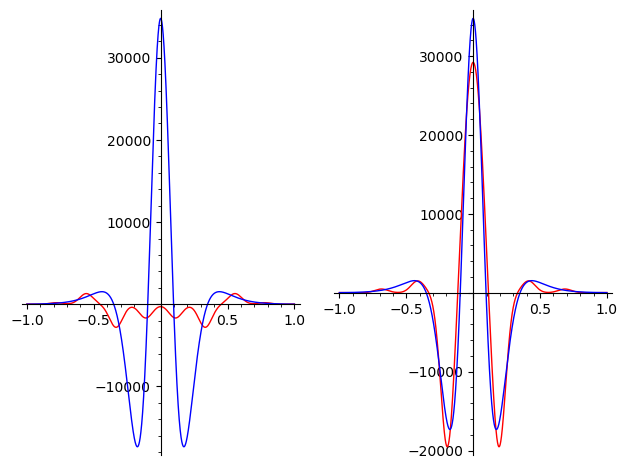

In [119]:
# Shows the relevancy of having a grid concentrated around a critical point

f=phi_funcs[0]

res, app, err,cond = fit_num_ridge(f, basis_pts=grid(1,10),train_pts=grid(1,1000), basis_type='G', sigma=1/20)
line1 = plot(app, (x, -1, 1),color='red')
line2 = plot(f, (x, -1, 1),color='blue')

res, app, err,cond = fit_num_ridge(f, basis_pts=grid_concentrated(-1,1,0,10),train_pts=grid(1,1000), basis_type='G', sigma=1/20)
line3 = plot(app, (x, -1, 1),color='red')
line4 = plot(f, (x, -1, 1),color='blue')

show(graphics_array([line1+line2, line3+line4], nrows=1))

In [ ]:
# First example with a nice function. We can observe that despite the fact that the gaussian kernel converges quite fast to a relevant approximation, the rate of convergence is pretty slow :
# L^2 error for a 20x20 grid : [0.24213298354645611527009855379086081525972906766468991270626727048507704464817209359 +/- 4.99e-84]
# L^2 error for a 40x40 grid : [0.1974516062190444277100886883318386625328517213038835652180062289031507379219911395 +/- 3.23e-83]
# L^2 error for a 80x80 grid : [0.188610547052896253372045283291878139980266698584153672865610066685072596406232665349 +/- 7.58e-85]

A=4
K=fast_callable(sin(x)*cos(y),vars=[x,y],domain=RBF)
K_approx = compute_approx_kernel(K,-A,A,-A,A,20,20,500,1)

print(f"L^2 norm of the difference = {riemann_integral(delta_squared(K,K_approx),-A,A,-A,A,40)}")

plot1=plot3d(sin(x)*cos(y),(x,-A,A),(y,-A,A),color='blue')
plot2=plot3d(K_approx,(x,-A,A),(y,-A,A),color='red')
plot3=plot3d(delta_squared(K,K_approx),(x,-A,A),(y,-A,A),color='purple')
L=[plot1,plot2,plot1+plot2,plot3]
h = sum(L[i].translate((i*(2*A+1),0,0)) for i in range(len(L)))
h.show()

MSE max = 1.442118368626133e-08 ; MSE average: 8.02326941084146e-09
Condition max = 2.5240673348636376e+16 ; Condition average: 2.5240673348636376e+16
L^2 norm of the difference = [0.2083366851658574090284307970094041015795143338406302144790208393936565470905827839426 +/- 4.81e-86]


Graphics3d Object

In [55]:
# Shows that for a function that has a sharp increase around the edges of the approximation domain, it is better to approximate on a wider domain, even if is with the same number of gaussians and thus a worst MSE error.

A=1
B=2
K=fast_callable(x**3 +y**2,vars=[x,y],domain=RBF)
K_approx1 = compute_approx_kernel(K,-A,A,-A,A,15,15,1000,1)
K_approx2 = compute_approx_kernel(K,-B,B,-B,B,15,15,1000,1)

print(f"L^2 norm of the difference learned on the small domain = {riemann_integral(delta_squared(K,K_approx1),-A,A,-A,A,50)}")
print(f"L^2 norm of the difference learned on the big domain = {riemann_integral(delta_squared(K,K_approx2),-A,A,-A,A,50)}")

plot1=plot3d(x**3 +y**2,(x,-A,A),(y,-A,A),color='blue')
plot2=plot3d(K_approx1,(x,-A,A),(y,-A,A),color='red')
plot3=plot3d(K_approx2,(x,-A,A),(y,-A,A),color='red')
plot4=plot3d(delta_squared(K,K_approx1),(x,-A,A),(y,-A,A),color='purple')
plot5=plot3d(delta_squared(K,K_approx2),(x,-A,A),(y,-A,A),color='purple')
L=[plot1+plot2,plot4,plot1+plot3,plot5]
h = sum(L[i].translate((i*(2*A+1),0,0)) for i in range(len(L)))
h.show()

MSE max = 1.3364095521017646e-06 ; MSE average: 1.2935553866213524e-06
Condition max = 5.862556219206423e+16 ; Condition average: 5.862556219206425e+16
MSE max = 8.924851671931696e-05 ; MSE average: 8.910868309716771e-05
Condition max = 1320221494634.3562 ; Condition average: 1320221494634.356
L^2 norm of the difference learned on the small domain = [0.2290037970443150448490037705614565705982498658704085349057323271716318807221153580047 +/- 3.26e-86]
L^2 norm of the difference learned on the big domain = [0.0587945346214720840973758960088946178184118566452284661642048169836017913266318497083 +/- 8.42e-86]


Graphics3d Object

In [ ]:
# L^2 norm of the kernel on [-1,1]x[-1,1] = [133184377.97029109084252063996471540429154453286521468500387428956233104601941883554 +/- 8.27e-75]
# L^2 norm of the difference on [-1,1]x[-1,1] = [131354647.55096026783485651175729485990453503817095921034377021849013400102470583966 +/- 4.87e-75]

A=RBF(1)
B=RBF(1.5)
K=M_0_func
K_approx = compute_approx_kernel(K,-B,B,-B,B,30,30,500,1/5)

print(riemann_integral(delta_squared(K,K_approx),-A,A,-A,A,50))

In [ ]:
# Convergence away from zero :
# L^2 norm of the kernel on [10,12]x[10,12] = [0.0010092916923795511366695502161549058852235974268804438998524792498315717801139176994807 +/- 3.18e-89]
# L^2 norm of the difference on [10,12]x[10,12] = [0.00012355900719952420240488209659077634751891724494739469294537574928294750352109 +/- 4.48e-81]

x1=10
x2=12
y1=10
y2=12

K=M_0_func
K_approx = compute_approx_kernel(K,x1,x2,y1,y2,30,30,500,1)

print(riemann_integral(delta_squared(K,lambda x,y:0),x1,x2,y1,y2,40))
print(riemann_integral(delta_squared(K,K_approx),x1,x2,y1,y2,40))

plot1=plot3d(K,(x,x1,x2),(y,y1,y2),color='blue')
plot2=plot3d(K_approx,(x,x1,x2),(y,y1,y2),color='red')
plot3=plot3d(delta_squared(K,K_approx),(x,x1,x2),(y,y1,y2),color='purple')
L=[plot1,plot2,plot1+plot2,plot3]
h = sum(L[i].translate((3*i,0,0)) for i in range(len(L)))
h.show()


MSE max = 3.568164853087532e-08 ; MSE average: 1.1596160173393079e-08
[0.0010092916923795511366695502161549058852235974268804438998524792498315717801139176994807 +/- 3.18e-89]
[0.00012355900719952420240488209659077634751891724494739469294537574928294750352109 +/- 4.48e-81]


Graphics3d Object

In [1]:
x1=2
x2=3
y1=0
y2=1

K=lambda x,y: M_0_func(x,y)
K_approx = compute_approx_kernel(K,x1,x2,y1,y2,10,10,100,1)

print(riemann_integral(delta_squared(K,lambda x,y:0),x1,x2,y1,y2,40))
print(riemann_integral(delta_squared(K,K_approx),x1,x2,y1,y2,40))

# show(plot3d(K,(x,x1,x2),(y,y1,y2),color='blue'))
# show(plot3d(K_approx,(x,x1,x2),(y,y1,y2),color='red'))

NameError: name 'compute_approx_kernel' is not defined

In [7]:

show(plot3d(K,(x,x1,x2),(y,y1,y2),color='blue'))
show(plot3d(K_approx,(x,x1,x2),(y,y1,y2),color='red'))

Graphics3d Object

Graphics3d Object

In [64]:
x1=-1
x2=1
y1=-1
y2=1

K=lambda x,y: 1/((RBF(x)-RBF(y))**2 +RBF(1e-1))
K_approx = compute_approx_kernel(K,x1,x2,y1,y2,30,30,1000,1/2)

print(riemann_integral(delta_squared(K,lambda x,y:0),x1,x2,y1,y2,30))
print(riemann_integral(delta_squared(K,K_approx),x1,x2,y1,y2,30))

# plot1=plot3d(K,(x,x1,x2),(y,y1,y2),color='blue')
# plot2=plot3d(K_approx,(x,x1,x2),(y,y1,y2),color='red')
# plot3=plot3d(delta_abs(K,K_approx),(x,x1,x2),(y,y1,y2),color='purple')
# L=[plot1,plot2,plot1+plot2,plot3]
# h = sum(L[i].translate((3*i,0,0)) for i in range(len(L)))
# h.show()

MSE max = 0.0004166366438154052 ; MSE average: 0.0001528821985208887
[89.5026987392285765114781957359478071487944239996136862353518664383658004974729287880550 +/- 3.71e-86]
[11.51640945873016836445822817370278104422881402148836118588653396115152378119214 +/- 7.81e-78]
